### Spatial EDA

#### I. Load Data

In [1]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import contextily as ctx
import geopandas as gpd
import libpysal as ps 
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from shapely.geometry import Point, polygon, box
import rasterio
import raster4ml
import requests
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

#### II. Mapping Distributions

/tmp/ipykernel_12389/191030677.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outside_tx = big_box.difference(tx_boundary.unary_union)
/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Data Centers and Electricity Generation Plants in Texas')

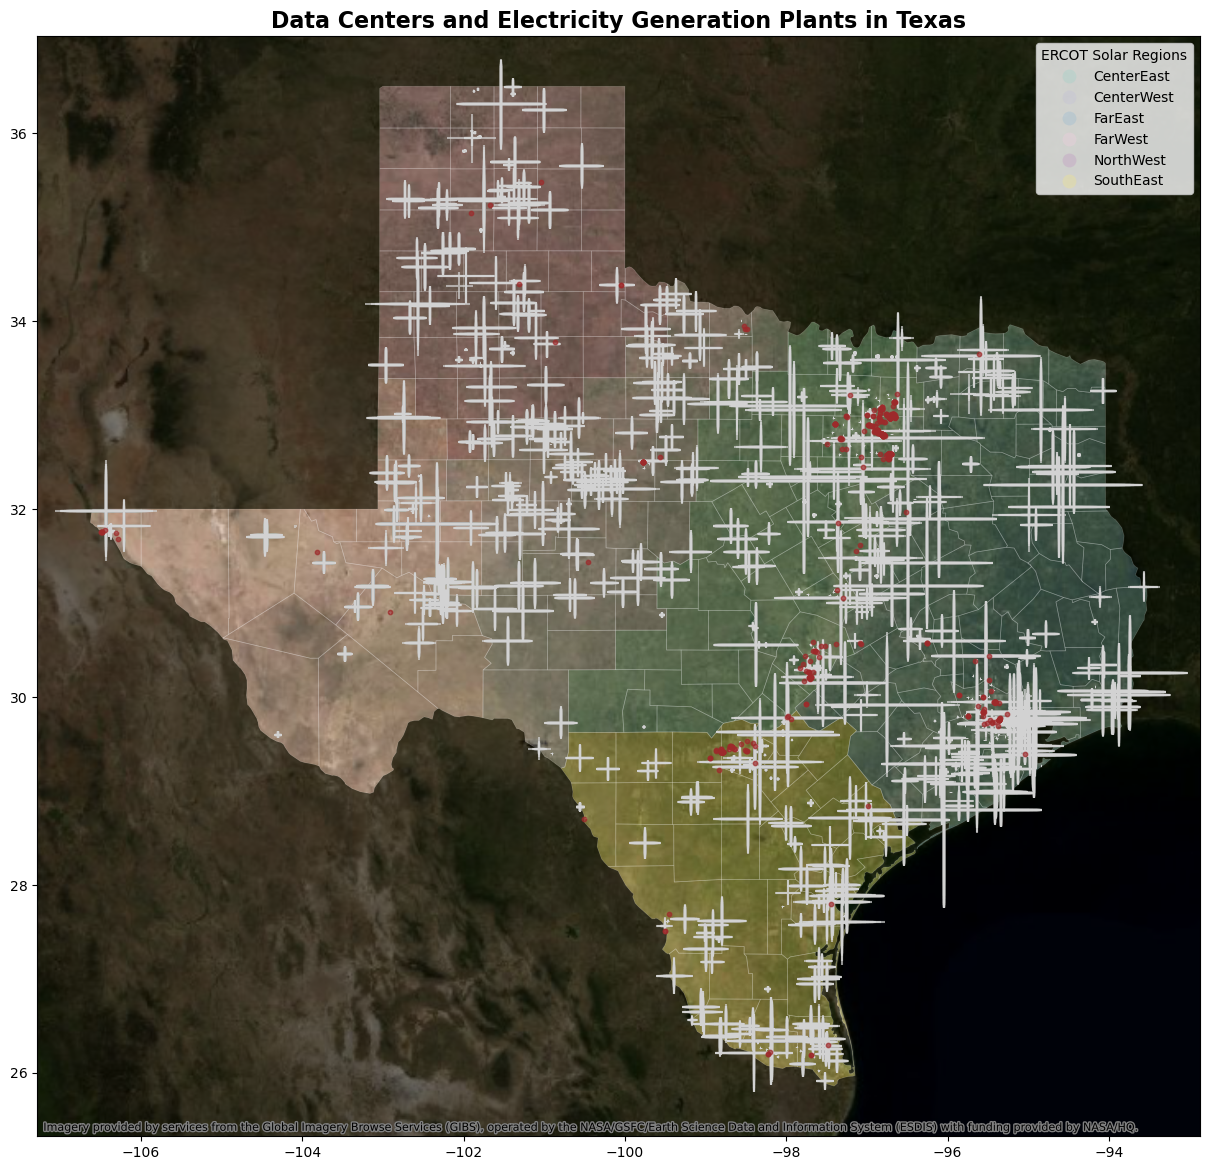

In [47]:
# Visualize Ercot Regions with Power Plants and Datacenters
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
#tx_counties.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
counties_gdf.plot(column='Solar Region', ax=ax, alpha=0.25, legend=True, cmap='Set3', edgecolor= 'white', linewidth=0.5, legend_kwds={'title': 'ERCOT Solar Regions'})

ctx.add_basemap(ax = ax, crs = tx_counties.crs, source = ctx.providers.NASAGIBS.BlueMarble)

#Add mask
tx_boundary = tx_counties.dissolve()
big_box = box(tx_counties.total_bounds[0]-100000, tx_counties.total_bounds[1]-100000, tx_counties.total_bounds[2]+100000, tx_counties.total_bounds[3]+100000)
outside_tx = big_box.difference(tx_boundary.unary_union)
gpd.GeoSeries([outside_tx], crs='EPSG:3857').plot(ax=ax, color='black', alpha=0.5, zorder=5)

# Plot power plants by total generation
power_plants_gdf = gpd.GeoDataFrame(total_monthly_egen_by_fueltype, geometry=total_monthly_egen_by_fueltype['geometry'], crs='EPSG:4326')
# power_plants_gdf = power_plants_gdf.to_crs(tx_counties.crs)
power_plants_gdf.plot(ax=ax, color = 'lightgrey', markersize = power_plants_gdf['total_generation'] * 0.005, legend=True, marker = '+', alpha=0.7, 
                      legend_kwds={'label': 'Total Electricity Generation (MWh)', 'orientation': 'vertical', 'shrink': 0.7}, zorder=8)

tx_datacenters_gdf.plot(ax=ax, color='#9e2a2b', markersize= 10, alpha=0.7, edgecolor='#9e2a2b', label='Datacenters', zorder=10)       
ax.set_title('Data Centers and Electricity Generation Plants in Texas', fontsize=16, fontweight='bold')

#### III. Spatial Weights Matrix

Justification: 

#### IV. Global Moran's I

In [ ]:
datacenter_agg_weather = datacenter_agg_weather.set_geometry('geometry_x')

In [67]:
datacenter_agg_weather = datacenter_agg_weather.to_crs(epsg=3857)

In [68]:
datacenter_agg_weather = datacenter_agg_weather.dropna(subset=['wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_std'])
#  Create spatial weights matrix we will use the k-nearest neighbors)
w = ps.weights.KNN.from_dataframe(datacenter_agg_weather, k=8) # k is the number of nearest neighbors we want to use in the comparison, here
w.transform = 'r' # row-standardize the weights

# Calculate Moran's I for Max Values of Wet Bulb Temperature
moran_wet_bulb_max = Moran(datacenter_agg_weather['wet_bulb_temperature_2m_max'], w) #This sets up a Moran's I analysis of the CMDEV data
print(f"Moran's I for Max of Wetbulb Temperature variable: {moran_wet_bulb_max.I:.4f}")
#The print statement above is: moran_wet_bulb.I return the moran I's value; abbreviate the value at four decimal places and format as a
print(f"Expected I: {moran_wet_bulb_max.EI:.4f}") #Expected I
print(f"p-value: {moran_wet_bulb_max.p_norm:.4f}")#p-value
print(f"z-score: {moran_wet_bulb_max.z_norm:.4f}")#z-score

# Calculate Moran's I for Standard Deviation of Wet Bulb Temperature
moran_wet_bulb_std = Moran(datacenter_agg_weather['wet_bulb_temperature_2m_std'], w) #This sets up a Moran's I analysis of the RM data
#breakdown of the following code is the same as above
print(f"\nMoran's I for Standard Deviation of Wet Bulb Temperature variable: {moran_wet_bulb_std.I:.4f}")
print(f"Expected I: {moran_wet_bulb_std.EI:.4f}")
print(f"p-value: {moran_wet_bulb_std.p_norm:.4f}")
print(f"z-score: {moran_wet_bulb_std.z_norm:.4f}")

Moran's I for Max of Wetbulb Temperature variable: 0.8805
Expected I: -0.0026
p-value: 0.0000
z-score: 37.9385

Moran's I for Standard Deviation of Wet Bulb Temperature variable: 0.9611
Expected I: -0.0026
p-value: 0.0000
z-score: 41.3993


/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


#### V. LISA (Local Moran's I)

In [70]:
# Compute Spatial Weights
k = 10
w = ps.weights.KNN.from_dataframe(datacenter_agg_weather, k=k)
w.transform = 'r'

# Compute LISA
y = datacenter_agg_weather['wet_bulb_temperature_2m_mean'].values
lisa_wet_bulb = Moran_Local(y, w, permutations=999)

/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [71]:
# Save LISA results to DataFrame
datacenter_agg_weather['lisa_I'] = lisa_wet_bulb.Is                  # Local I statistics
datacenter_agg_weather['lisa_p'] = lisa_wet_bulb.p_sim             # Permutation-based p-values
datacenter_agg_weather['lisa_q'] = lisa_wet_bulb.q                # Quadrant location: 1=HH, 2=LH, 3=LL, 4=HL

Visualize Moran's I and LISA on Texas Counties Map

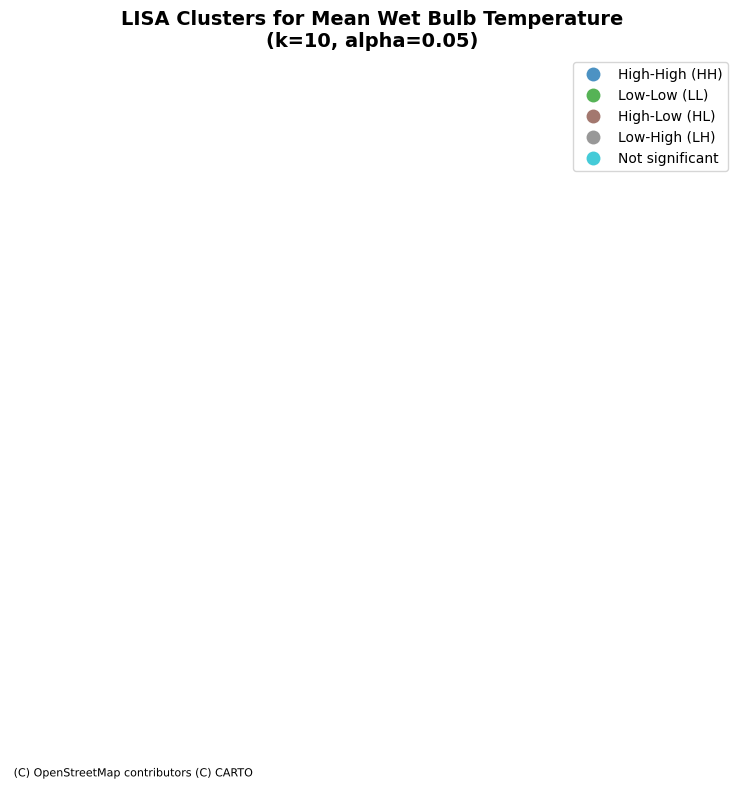

In [78]:
# define cluster labels with significance at 0.05 alpha level
alpha = 0.05 #This is not transparecny, it is the alpha level for the statistical significance test
signif = datacenter_agg_weather["lisa_p"] < alpha
# here we use the else,if, elif to create categories of the LISA statistic results. The classification is described below
def label_from_q(row):
    if not row["lisa_p"] < alpha:
        return "Not significant"
    q = int(row["lisa_q"]) #lisa q is the quadrant
    # Common categorical divisions for Moran_Local.q:
    # 1 = High-High (HH)
    # 2 = Low-High (LH) -> low value surrounded by high neighbors (spatial outlier)
    # 3 = Low-Low (LL)
    # 4 = High-Low (HL) -> high value surrounded by low neighbors (spatial outlier)
    if q == 1:
        return "High-High (HH)"
    elif q == 2:
        return "Low-High (LH)"
    elif q == 3:
        return "Low-Low (LL)"
    elif q == 4:
        return "High-Low (HL)"
    else:
        return "Other"
datacenter_agg_weather["lisa_cluster"] = datacenter_agg_weather.apply(label_from_q, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
category_order = ["High-High (HH)", "Low-Low (LL)", "High-Low (HL)", "Low-High (LH)", "Not significant"]
# create a categorical column with ordered categories for consistent plotting
datacenter_agg_weather["lisa_cluster"] = pd.Categorical(datacenter_agg_weather["lisa_cluster"], categories=category_order)
# Plot: choose a colormap yourself if desired; here we let geopandas use its defaults


ctx.add_basemap(ax = ax, crs = datacenter_agg_weather.crs , source = ctx.providers.CartoDB.Positron, zoom=6, zorder=1)

datacenter_agg_weather.plot(column="lisa_cluster", categorical=True, legend=True, markersize=20, alpha=0.8, ax=ax, zorder=20)
ax.set_title(f'LISA Clusters for Mean Wet Bulb Temperature\n(k={k}, alpha={alpha})', fontsize=14, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
# LISA Cluster Map

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
tx_counties.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.3)

# Create categorical column with ordered categories
category_order = ["High-High (HH)", "Low-Low (LL)", "High-Low (HL)", "Low-High (LH)", "Not significant"]
datacenter_agg_weather["lisa_cluster"] = pd.Categorical(
    datacenter_agg_weather["lisa_cluster"], 
    categories=category_order, 
    ordered=True)

# # Convert to CRS matching Texas counties if needed
# if datacenter_agg_weather.crs != tx_counties.crs:
#     datacenter_agg_weather_proj = datacenter_agg_weather.to_crs(tx_counties.crs)
# else:
#     datacenter_agg_weather_proj = datacenter_agg_weather

# Define custom colors for LISA categories
colors = {'High-High (HH)': '#d7191c',      # red
          'Low-Low (LL)': '#2b83ba',        # blue
          'High-Low (HL)': '#fdae61',       # orange
          'Low-High (LH)': '#abdda4',       # light green
          'Not significant': '#e0e0e0'}     # grey

# Plot LISA clusters
datacenter_agg_weather_proj.plot(column="lisa_cluster", categorical=True, 
                                legend=True, markersize=100, alpha=0.8, ax=ax,
                                cmap='RdYlBu_r', edgecolor='black', linewidth=0.5,
                                legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'title': 'LISA Cluster Type'})

ax.set_title(f'LISA Clusters for Mean Wet Bulb Temperature\n(k={k}, alpha={alpha})', fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()

#### VI. Findings and Next Steps

What does this mean for modeling? 